In [595]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [596]:
#Abro el archivo
props = pd.read_csv('propiedades.csv')
props.drop('precio_x_m2', axis=1, inplace=True)

In [597]:
props.head(2)

,Unnamed: 0,titulo,tipo_inmueble,precio,latitud,longitud,tamaño_m2,habitaciones,banios,direccion,descripcion,caracteristicas,url,distrito
0,0,"Departamento en venta Los Angeles De Cayma 30,...",departamento,152500.0,-16.380099,-71.552289,147.0,4.0,4.0,"Los angeles de cayma 30, arequipa 04017, perú","Vendo departamento en el Tercer Piso, en la Ur...",Amoblado: Sin amoblar Armario empotrado Línea ...,https://www.laencontre.com.pe/inmueble/ed7c-b3...,cayma
1,1,Departamento en venta Residencial Villa Aurora...,departamento,120000.0,-16.439627,-71.514888,129.3,3.0,3.0,"Residencial villa aurora, josé luis bustamante...",Departamento dúplex en preventa muy lindo y ac...,Amoblado: Semi-amoblado Año de construcción: 2...,https://www.laencontre.com.pe/inmueble/511a-90...,bustamante


In [598]:
#Elimino esta columna innnecesaria
props.drop('Unnamed: 0', axis=1, inplace=True)

In [599]:
#Reviso una vez más el estado del dataframe
props.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   titulo           612 non-null    object 
 1   tipo_inmueble    612 non-null    object 
 2   precio           612 non-null    float64
 3   latitud          612 non-null    float64
 4   longitud         612 non-null    float64
 5   tamaño_m2        612 non-null    float64
 6   habitaciones     612 non-null    float64
 7   banios           612 non-null    float64
 8   direccion        612 non-null    object 
 9   descripcion      612 non-null    object 
 10  caracteristicas  578 non-null    object 
 11  url              612 non-null    object 
 12  distrito         612 non-null    object 
dtypes: float64(6), object(7)
memory usage: 62.3+ KB


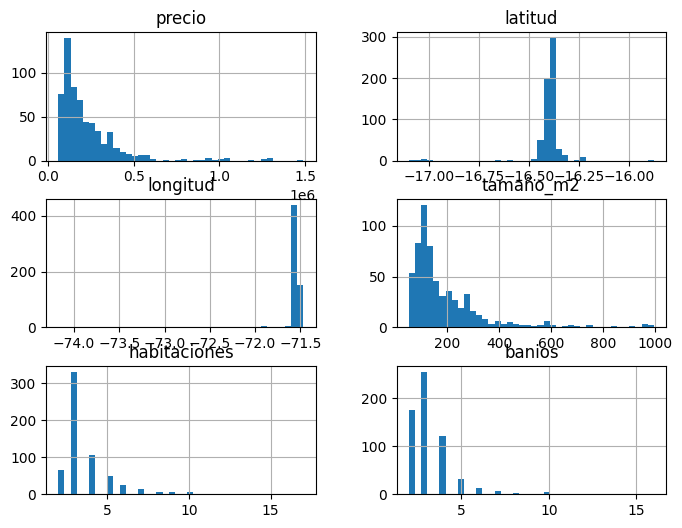

In [600]:
props.hist(bins=40, figsize=(8,6))
plt.show()

In [601]:
#Hago la separación entre train y test:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(props, test_size=0.1, random_state=42)

In [602]:
#Defino 4 categorías entre los valores de "tamaño_m2" para hacer un muestreo estratificado
props['tamañom2_cat'] = pd.cut(props['tamaño_m2'], bins= [0,300,600,900, np.inf], labels= [1,2,3,4])

In [603]:
#Hago un muestreo estratificado de los valores en la columna de tamaño_m2
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(test_size=0.1, random_state=42)
for train_index, test_index in split.split(props, props['tamañom2_cat']):
    strat_train_set = props.loc[train_index]
    strat_test_set = props.loc[test_index]

In [604]:
strat_test_set['tamañom2_cat'].value_counts()/len(strat_test_set)

1    0.887097
2    0.096774
3    0.016129
4    0.000000
Name: tamañom2_cat, dtype: float64

In [605]:
#ya no necesito esta columna
for column in (strat_train_set, strat_test_set):
    column.drop('tamañom2_cat', axis=1, inplace=True)

<h2> Nuevos atributos

Ya que los datos proporcionados por el scraping son escasos (menos de 600), el modelo puede tener problemas para entrenarse correctamente. Para ayudarle, voy a crear dos nuevos atributos para cada inmueble, que puede que no sean muy útiles al momento de comprar una casa, pero sí para que el modelo se entrene más precisamente: <br>
1. Tamaño máximo por habitación: Un aproximado del tamaño máximo que puede tener una habitación en el inmueble. <br>
2. Proporción baños por habitación: Calcula cuántos baños tiene el inmueble por cada habitación

In [606]:
props['rooms_mxsize'] = props['tamaño_m2']/props['habitaciones']
props['baths_per_rooms'] = props['habitaciones']/props['banios']

In [607]:
corr_matrix = props.corr()
corr_matrix['precio'].sort_values(ascending=False)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15168\3809295541.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = props.corr()


precio             1.000000
tamaño_m2          0.807205
rooms_mxsize       0.658880
banios             0.498352
habitaciones       0.422662
latitud            0.040800
baths_per_rooms   -0.034204
longitud          -0.052909
Name: precio, dtype: float64

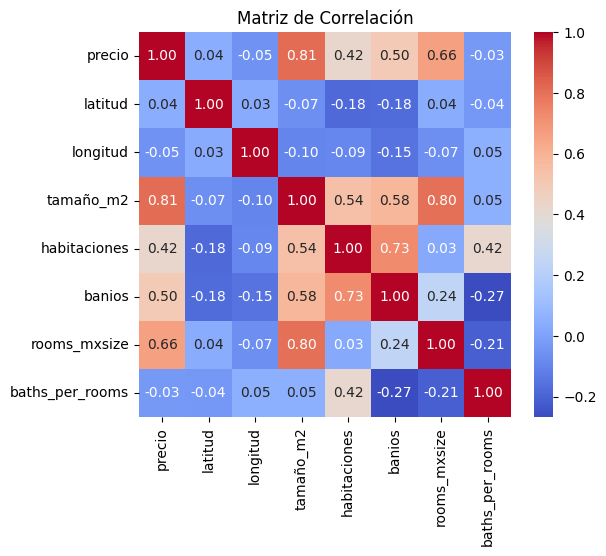

In [608]:
#Grafico las correlaciones
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()


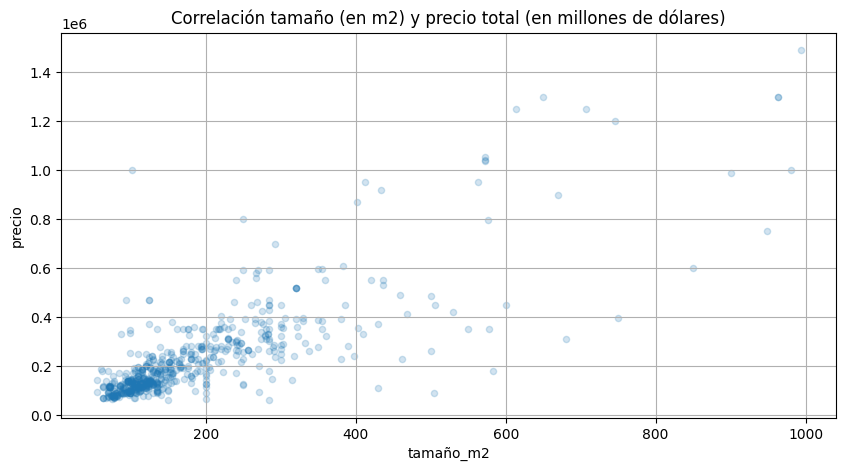

In [609]:
#Parece ser que la variable con mayor peso es el tamaño del inmueble, volvamos a darle una vista más de cerca:
props.plot(kind='scatter', x='tamaño_m2', y='precio', alpha=0.2, figsize=(10,5))
plt.title('Correlación tamaño (en m2) y precio total (en millones de dólares)')
plt.grid()

<h2> Preprocesamiento

In [610]:
#Separo el dataframe de entrenamiento en atributos y etiquetas
props = strat_train_set.drop('precio', axis=1)
props_labels = strat_train_set['precio'].copy()

In [611]:
#Separo las características numéricas y categóricas que se usarán para entrenar el modelo
props_num = props[['latitud', 'longitud', 'tamaño_m2', 'habitaciones', 'banios']]
props_cat = props[['tipo_inmueble','distrito']]

<h2> Pipelines de procesamiento automatizado

In [612]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

In [637]:
props.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 550 entries, 425 to 289
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   titulo           550 non-null    object 
 1   tipo_inmueble    550 non-null    object 
 2   latitud          550 non-null    float64
 3   longitud         550 non-null    float64
 4   tamaño_m2        550 non-null    float64
 5   habitaciones     550 non-null    float64
 6   banios           550 non-null    float64
 7   direccion        550 non-null    object 
 8   descripcion      550 non-null    object 
 9   caracteristicas  521 non-null    object 
 10  url              550 non-null    object 
 11  distrito         550 non-null    object 
dtypes: float64(5), object(7)
memory usage: 55.9+ KB


Este Pipeline procesa automáticamente los datos numéricos: <br>
1. Imputa los datos faltantes con la mediana
2. Usa StandartScaler() para escalarlos

In [613]:
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')), #Aunque no haga falta, instancio un imputador de datos faltantes, por si el dataset crece en el futuro
    ('stdscaler', StandardScaler()),
])

props_num_ready = num_pipeline.fit_transform(props_num)

Este Pipeline integra el procesamiento de los datos numéricos con los categóricos: <br>
1. Llama al Pipeline de procesamiento numérico
2. Usa OneHotEncoder() para convertir los datos categóricos a numéricos
3. Devuelve los datos preparados en "props_ready"

In [614]:
#Pipeline completo
from sklearn.compose import ColumnTransformer

num_attribs = list(props_num)
cat_attribs = ['tipo_inmueble', 'distrito']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

props_ready = full_pipeline.fit_transform(props)

A partir de aquí, itero sobre tres diferentes regresores de scikit-learn (Linear, Decision Tree y Random Forest),
evaluándolos con validación cruzada, para obtener el regresor que ofrece mejor precisión en las predicciones para este proyecto:

<h2> Linear Regression

In [638]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(props_ready, props_labels)

LinearRegression()

In [639]:
#Hago una pequeña prueba con una muestra de 5 datos:
pocos_datos = props.iloc[:5]
pocas_labels = props_labels.iloc[:5]
pocos_datos_ready = full_pipeline.transform(pocos_datos)
print('predicciones:',lin_reg.predict(pocos_datos_ready))
print('etiquetas:', list(pocas_labels))

predicciones: [266796.69805962  89991.55240181 166400.00137091 158872.63005087
 202374.19239426]
etiquetas: [325000.0, 90000.0, 140000.0, 158000.0, 230000.0]


In [642]:
#Calculo el RMSE del regresor lineal
from sklearn.metrics import mean_squared_error
props_predictions = lin_reg.predict(props_ready)
lin_mse = mean_squared_error(props_labels, props_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

102427.84804852137

<h2> Decision Tree Regressor

In [667]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()

In [668]:
tree_reg.fit(props_ready, props_labels)
props_predictions = tree_reg.predict(props_ready)

In [669]:
#Calculo el RMSE del decision tree
tree_mse = mean_squared_error(props_labels, props_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

1874.8191172827362

<H2> Cross Val

Comparo el rendimiento de ambos modelos previos con cross validation, con 10 folds, usando como puntaje el error cuadrático medio negativo

In [646]:
def mostrar_scores(scores):
    print('Scores: ', scores)
    print('Mean: ', scores.mean())
    print('Std deviation: ', scores.std())

In [651]:
from sklearn.model_selection import cross_val_score

tree_scores = cross_val_score(tree_reg, props_ready, props_labels,
                         scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)

mostrar_scores(tree_rmse_scores)

Scores:  [156736.64926009 203014.96759746 107192.57229727 148330.37252422
 140727.99478393  76634.21650208 116180.64493046 115706.36839302
  63117.22719329 147793.32626693]
Mean:  127543.43397487488
Std deviation:  38716.9924106827


In [650]:
#lo mismo, para la regresion lineal
lin_scores = cross_val_score(lin_reg, props_ready, props_labels,
                         scoring='neg_mean_squared_error', cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)

mostrar_scores(lin_rmse_scores)

Scores:  [109986.12265172 166913.24217408 109975.93812531 109076.39474877
 127700.47822528 136549.33405839  75374.56398277 109697.41981992
  99254.61319602  93297.58680913]
Mean:  113782.56937913861
Std deviation:  23892.494696791193


In [648]:
#El TreeRegressor parece rendir mejor

<h3> Random Forest

In [655]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(props_ready, props_labels)

RandomForestRegressor()

In [652]:
#Uso el mismo método para evaluar el rendimiento del Random Forest 
forest_scores = cross_val_score(forest_reg, props_ready, props_labels,
                                scoring= 'neg_mean_squared_error', cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)

mostrar_scores(forest_rmse_scores)

Scores:  [110582.83324225 158250.5217722   78532.73288238  91260.33712307
 115346.06184015 106491.46033379  85466.78735753 106849.04804934
  63803.40055888  64176.94031936]
Mean:  98076.01234789456
Std deviation:  26710.6297981858


In [656]:
#Y también calculo su RMSE
forest_predictions = forest_reg.predict(props_ready)
forest_mse = mean_squared_error(props_labels, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

37318.539216792575

El Random Forest y el Decision Tree tienen los mejores puntajes, por lo que los afinaré con GridSearchCV() para encontrar sus mejores hiperparámetros y evaluarlos con el set de test

In [628]:
from sklearn.model_selection import GridSearchCV
param_grid = [
    {'n_estimators': [3,10,30], 'max_features':[2,4,6,8]},
    {'bootstrap':[False], 'n_estimators':[3,10],'max_features':[2,3,4]}
,]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring= 'neg_mean_squared_error', return_train_score = True)

In [629]:
grid_search.fit(props_ready, props_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [630]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [631]:
grid_search.best_estimator_


RandomForestRegressor(max_features=8, n_estimators=30)

In [632]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

136220.7925839614 {'max_features': 2, 'n_estimators': 3}
116420.13684957106 {'max_features': 2, 'n_estimators': 10}
116691.51816178695 {'max_features': 2, 'n_estimators': 30}
121403.48774377715 {'max_features': 4, 'n_estimators': 3}
112020.62936047926 {'max_features': 4, 'n_estimators': 10}
114477.18076505902 {'max_features': 4, 'n_estimators': 30}
128693.8710732803 {'max_features': 6, 'n_estimators': 3}
109807.85650762706 {'max_features': 6, 'n_estimators': 10}
109732.07813653661 {'max_features': 6, 'n_estimators': 30}
126089.21351979497 {'max_features': 8, 'n_estimators': 3}
109824.30623526943 {'max_features': 8, 'n_estimators': 10}
107557.39177520703 {'max_features': 8, 'n_estimators': 30}
124030.21381663704 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
116902.69220117644 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
131020.91398867368 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
113062.55330857623 {'bootstrap': False, 'max_features': 3, 'n_e

Evaluación Final

In [657]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('precio', axis=1)
y_test = strat_test_set['precio'].copy()

X_test_ready = full_pipeline.transform(X_test)
final_pred = final_model.predict(X_test_ready)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

91742.09834068619

Ahora con el decision tree

In [662]:
from sklearn.model_selection import GridSearchCV
param_grid_tree = {
    'criterion': ['mse', 'friedman_mse', 'mae'],  # Funciones para medir la calidad de la división
    'splitter': ['best', 'random'],  # Estrategia para elegir la división en cada nodo
    'max_depth': [None, 10, 20, 30],  # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4],  # Número mínimo de muestras requeridas en un nodo hoja
    'max_features': ['auto', 'sqrt', 'log2', None],  # Número máximo de características a considerar en cada división
}


tree_reg = DecisionTreeRegressor()
grid_search_tree = GridSearchCV(tree_reg, param_grid_tree, cv=5, scoring= 'neg_mean_squared_error', return_train_score = True)

In [663]:
grid_search_tree.fit(props_ready, props_labels)

c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0'`.
  warnings.warn(
c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\tree\_classes.py:277: FutureWarning: `max_features='auto'` has been deprecated in 1

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['mse', 'friedman_mse', 'mae'],
                         'max_depth': [None, 10, 20, 30],
                         'max_features': ['auto', 'sqrt', 'log2', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [665]:
grid_search_tree.best_estimator_


DecisionTreeRegressor(criterion='friedman_mse', max_depth=30,
                      min_samples_leaf=2, splitter='random')

In [666]:
tree_model = grid_search_tree.best_estimator_

X_test = strat_test_set.drop('precio', axis=1)
y_test = strat_test_set['precio'].copy()

X_test_ready = full_pipeline.transform(X_test)
final_pred = tree_model.predict(X_test_ready)

final_mse = mean_squared_error(y_test, final_pred)
final_rmse = np.sqrt(final_mse)
final_rmse

102524.75579049038

El modelo con mejor rendimiento fue el Random Forest Regressor. Sin embargo, su RMSE aún es alto, probablemente debido a la muestra de datos escasa que tuvo para entrenarse. <br>
<br>
¿Ahora qué sigue?<br>
- Iré actualizando el modelo y poniendo a prueba modelos más complejos para evaluar su rendimiento en comparación <br>
- Idealmente, encontraré la forma de mejorar el tamaño de la muestra de datos para entrenar el modelo <br>

<br>
Gracias por leer hasta aquí!